In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import ast
from tqdm import tqdm
from collections import defaultdict

In [2]:
# install these
#https://pymicro.readthedocs.io/projects/pymicro/en/latest/cookbook/pointset_registration.html
from pymicro.view.vol_utils import compute_affine_transform
#https://pypi.org/project/affine6p/
import affine6p
#https://github.com/jewettaij/superpose3d
from superpose3d import Superpose3D

In [3]:
HOME = os.path.expanduser("~")
DIR = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(DIR)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer, \
    create_full_volume, get_structure_colors
from utilities.sqlcontroller import SqlController
animal = 'MD589'
sqlController = SqlController(animal)

CSV_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/foundation_brain_annotations'
csvfile = os.path.join(CSV_PATH, 'MD589_annotation.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations.head()
hand_annotations['vertices'] = hand_annotations['vertices'] \
    .apply(lambda x: x.replace(' ', ','))\
    .apply(lambda x: x.replace('\n',','))\
    .apply(lambda x: x.replace(',]',']'))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ',')).apply(lambda x: x.replace(',,', ','))

hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))
structures = ['DC', 'LC','SC', '5N', '7n']
# SC is the only singular structure
df = hand_annotations[['name', 'section', 'side', 'vertices']].copy()
df = df.loc[df['name'].isin(structures)]
df = df.reset_index()
df = df.sort_values(by=['name', 'section'])
df.head()

Connecting dklab@192.168.1.12:3306


,index,name,section,side,vertices
191,843,5N,150,L,"[[23467.35736638, 13029.96696407], [23371.8771..."
369,1683,5N,151,L,"[[22119.53951512, 14078.59777646], [21969.6072..."
451,2089,5N,152,L,"[[23441.88459431, 13586.7746992], [23299.53025..."
116,489,5N,153,L,"[[22705.00744451, 13825.99679013], [22571.2393..."
49,198,5N,154,L,"[[22703.58621367, 14048.8018496], [22552.64526..."


In [4]:
# these are the 5 structures Beth suggested for getting
# enough that were spread out.
structures = ['DC', 'LC','SC', '5N', '7n']
centers = {}
section_structure_vertices = defaultdict(dict)
SC = df.loc[(df['name'] == "SC")]
first_section = SC['section'].min()
last_section = SC['section'].max()
midsection = int(round(((last_section + first_section) / 2)))
point_array = SC['vertices'].loc[SC['section'] == midsection].values
section_structure_vertices[midsection]['SC'] = point_array[0]
cx, cy = np.mean(point_array[0], axis=0)    
centers['SC'] = [int(round(cx)), int(round(cy)), int(round(midsection))]

structures.remove('SC')
for structure in structures:
    df_tmp = df.loc[(df['name'] == structure) & (df['side'] == "L")]
    first_section = df_tmp['section'].min()
    last_section = df_tmp['section'].max()
    midsection = int(round(((last_section + first_section) / 2)))
    structure_name = structure + "_L"
    point_array = df_tmp['vertices'].loc[df_tmp['section'] == midsection].values
    section_structure_vertices[midsection][structure_name] = point_array[0]
    cx, cy = np.mean(point_array[0], axis=0)    
    centers[structure_name] = [int(round(cx)), int(round(cy)), int(round(midsection))]
    
    df_tmp = df.loc[(df['name'] == structure) & (df['side'] == "R")]
    first_section = df_tmp['section'].min()
    last_section = df_tmp['section'].max()
    midsection = int(round(((last_section - first_section) / 2) + first_section))
    structure_name = structure + "_R"
    point_array = df_tmp['vertices'].loc[df_tmp['section'] == midsection].values
    section_structure_vertices[midsection][structure_name] = point_array[0]
    cx, cy = np.mean(point_array[0], axis=0)    
    centers[structure_name] = [int(round(cx)), int(round(cy)), int(round(midsection))]


In [5]:
centers

{'SC': [24226, 6401, 220],
 'DC_L': [24482, 11985, 134],
 'DC_R': [20424, 11736, 330],
 'LC_L': [25290, 11750, 180],
 'LC_R': [24894, 12079, 268],
 '5N_L': [23790, 13025, 160],
 '5N_R': [20805, 14163, 298],
 '7n_L': [20988, 18405, 177],
 '7n_R': [24554, 13911, 284]}

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
thickness = 1
colors = {}
colors['SC'] = (255,0,255)

colors['DC_L'] = (0,0,0)
colors['LC_L'] = (255,0,0)
colors['SC_L'] = (255,0,255)
colors['5N_L'] = (0,255,255)
colors['7n_L'] = (100,10,255)
colors['DC_R'] = (0,0,0)
colors['LC_R'] = (255,0,0)
colors['SC_R'] = (255,0,255)
colors['5N_R'] = (0,255,255)
colors['7n_R'] = (100,10,255)
# create a fake random distance away from the original structures
rand_offset = np.random.randint(75,150)
offsets = {}
section_images = {}
points = {}
SCALE = 32
PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1'
thumbnail_dir = os.path.join(PATH, 'thumbnail')
files = sorted(os.listdir(thumbnail_dir))
for file_name in tqdm(files):
    filepath = os.path.join(thumbnail_dir, file_name)
    img = cv2.imread(filepath)
    section = int(file_name.split('.')[0])
    
    for structure in section_structure_vertices[section]:
        pts = section_structure_vertices[section][structure]
        points = np.array(pts, dtype=np.int32)        
        points = points // SCALE
        
        points_diff = np.rint(points + rand_offset)
        points_diff = points_diff.astype(np.int32)
        cxoff, cyoff = np.min(points_diff, axis=0)
        offsets[structure] = [int(round(cxoff*SCALE)), int(round(cyoff*SCALE)), section]
        
        cv2.polylines(img, [points_diff], isClosed=True, color=(0,0,0), thickness=5)
        cx = centers[structure][0] // SCALE
        cy = centers[structure][1] // SCALE
        
        cv2.circle(img, (cx,cy), 10, (0,0,0), -1)
            
        cv2.polylines(img, [points], isClosed=True, color=colors[structure], thickness=2)
        cv2.putText(img, structure, (cx,cy), font,
                    fontScale, colors[structure], thickness, cv2.LINE_AA)
            
    section_images[section] = img

In [ ]:
# this shows the real structure, it's center of mass and a fake offsetted structure
structure_midpoints = [134,160,177,180,220,268,284,298,330]
section = structure_midpoints[0]
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(section_images[section], cmap="cool")
plt.title('{} section:{}'.format(animal, section))
plt.show()

In [ ]:
offsets

In [ ]:
origin = np.array(list(centers.values())).astype(np.float32)
fitted = np.array(list(offsets.values())).astype(np.float32)
# create a fake structure with a center of mass at:
other_structure = (25000,15000,200)
print(origin.shape, fitted.shape, other_structure)

In [ ]:
origin_centroid = np.mean(origin, axis=0)
fitted_centroid = np.mean(fitted, axis=0)
print(origin_centroid, fitted_centroid, other_structure)

In [ ]:
# Pad the data with ones, so that our transformation can do translations too
n = origin.shape[0]
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:,:-1]
X = pad(origin)
Y = pad(fitted)

# Solve the least squares problem X * A = Y
# to find our transformation matrix A
A, res, rank, s = np.linalg.lstsq(X, Y)

transform = lambda x: unpad(np.dot(pad(x), A))

print("Target:", fitted)
print("Result:", transform(origin))
print("Max error:", np.abs(fitted - transform(origin)).max())

In [ ]:
def Affine_Fit( from_pts, to_pts ):
    """Fit an affine transformation to given point sets.
      More precisely: solve (least squares fit) matrix 'A'and 't' from
      'p ~= A*q+t', given vectors 'p' and 'q'.
      Works with arbitrary dimensional vectors (2d, 3d, 4d...).

      Written by Jarno Elonen <elonen@iki.fi> in 2007.
      Placed in Public Domain.

      Based on paper "Fitting affine and orthogonal transformations
      between two sets of points, by Helmuth Späth (2003)."""

    q = from_pts
    p = to_pts
    if len(q) != len(p) or len(q)<1:
        print("from_pts and to_pts must be of same size.")
        return false

    dim = len(q[0]) # num of dimensions
    if len(q) < dim:
        print("Too few points => under-determined system.")
        return false

    # Make an empty (dim) x (dim+1) matrix and fill it
    c = [[0.0 for a in range(dim)] for i in range(dim+1)]
    for j in range(dim):
        for k in range(dim+1):
            for i in range(len(q)):
                qt = list(q[i]) + [1]
                c[k][j] += qt[k] * p[i][j]

    # Make an empty (dim+1) x (dim+1) matrix and fill it
    Q = [[0.0 for a in range(dim)] + [0] for i in range(dim+1)]
    for qi in q:
        qt = list(qi) + [1]
        for i in range(dim+1):
            for j in range(dim+1):
                Q[i][j] += qt[i] * qt[j]

    # Ultra simple linear system solver. Replace this if you need speed.
    def gauss_jordan(m, eps = 1.0/(10**10)):
      """Puts given matrix (2D array) into the Reduced Row Echelon Form.
         Returns True if successful, False if 'm' is singular.
         NOTE: make sure all the matrix items support fractions! Int matrix will NOT work!
         Written by Jarno Elonen in April 2005, released into Public Domain"""
      (h, w) = (len(m), len(m[0]))
      for y in range(0,h):
        maxrow = y
        for y2 in range(y+1, h):    # Find max pivot
          if abs(m[y2][y]) > abs(m[maxrow][y]):
            maxrow = y2
        (m[y], m[maxrow]) = (m[maxrow], m[y])
        if abs(m[y][y]) <= eps:     # Singular?
          return False
        for y2 in range(y+1, h):    # Eliminate column y
          c = m[y2][y] / m[y][y]
          for x in range(y, w):
            m[y2][x] -= m[y][x] * c
      for y in range(h-1, 0-1, -1): # Backsubstitute
        c  = m[y][y]
        for y2 in range(0,y):
          for x in range(w-1, y-1, -1):
            m[y2][x] -=  m[y][x] * m[y2][y] / c
        m[y][y] /= c
        for x in range(h, w):       # Normalize row y
          m[y][x] /= c
      return True

    # Augement Q with c and solve Q * a' = c by Gauss-Jordan
    M = [ Q[i] + c[i] for i in range(dim+1)]
    if not gauss_jordan(M):
        print("Error: singular matrix. Points are probably coplanar.")
        return false

    # Make a result object
    class Transformation:
        """Result object that represents the transformation
           from affine fitter."""

        def To_Str(self):
            res = ""
            for j in range(dim):
                str = "x%d' = " % j
                for i in range(dim):
                    str +="x%d * %f + " % (i, M[i][j+dim+1])
                str += "%f" % M[dim][j+dim+1]
                res += str + "\n"
            return res

        def Transform(self, pt):
            res = [0.0 for a in range(dim)]
            for j in range(dim):
                for i in range(dim):
                    res[j] += pt[i] * M[i][j+dim+1]
                res[j] += M[dim][j+dim+1]
            return res
    return Transformation()

In [ ]:
fitted

In [ ]:
from_pt = origin / 32
to_pt = fitted / 32
trn = Affine_Fit(from_pt, to_pt)
print("Transformation is:")
print(trn.To_Str())

err = 0.0
for i in range(len(from_pt)):
    fp = from_pt[i]
    tp = to_pt[i]
    t = trn.Transform(fp)
    print(t)
    #print ("%s => %s ~= %s" % (fp, tuple(t), tp))
    err += ((tp[0] - t[0])**2 + (tp[1] - t[1])**2)**0.5

print("Fitting error = %f" % err)

In [ ]:
x0, x1, x2  = other_structure
x0f = x0 * -0.097208 + x1 * -0.324479 + x2 * -12.578684 + 35205.477484
x1f = x0 * -1.295431 + x1 * -0.008414 + x2 * -5.637887 + 46289.989021
x2f = x0 * 0.006399 + x1 * 0.016787 + x2 * 0.304488 + -186.965984
#x0f = x0 * 0.078878 + x1 * -0.289671 + x2 * -10.340925 + 31461.282454
#x1f = x0 * -1.585760 + x1 * -0.302059 + x2 * -10.844655 + 59805.747884
#x2f = x0 * 0.011862 + x1 * 0.021107 + x2 * 0.388296 + -402.727965
print(x0f, x1f, x2f)

In [ ]:
A[np.abs(A) < 1e-2] = 0  # set really small values to zero
print(A)

In [ ]:
ins = np.array([[3531820.440, 1174966.736, 5162268.086],
                [3531746.800, 1175275.159, 5162241.325],
                [3532510.182, 1174373.785, 5161954.920],
                [3532495.968, 1175507.195, 5161685.049]]) # <- primary system
out = np.array([[6089665.610, 3591595.470, 148.810],
                [6089633.900, 3591912.090, 143.120],
                [6089088.170, 3590826.470, 166.350],
                [6088672.490, 3591914.630, 147.440]]) # <- secondary system
p = np.array([3532412.323, 1175511.432, 5161677.111]) #<- transform this point
print(ins.shape, out.shape, p.shape)
ins = origin[:4,:]
out = fitted[:4,:]
p = np.array(other_structure)
print(ins.shape, out.shape, p.shape)
# finding transformation
l = len(ins)
entry = lambda r,d: np.linalg.det(np.delete(np.vstack([r, ins.T, np.ones(l)]), d, axis=0))
M = np.array([[(-1)**i * entry(R, i) for R in out.T] for i in range(l+1)])
print('M',M)
A, t = np.hsplit(M[1:].T/(-M[0])[:,None], [l-1])
t = np.transpose(t)[0]
# output transformation
print("Affine transformation matrix:\n", A)
print("Affine transformation translation vector:\n", t)
# unittests
print("TESTING:")
for p, P in zip(np.array(ins), np.array(out)):
  image_p = np.dot(A, p) + t
  result = "[OK]" if np.allclose(image_p, P) else "[ERROR]"
  print(p, " mapped to: ", image_p, " ; expected: ", P, result)
# calculate points
print("CALCULATION:")
P = np.dot(A, p) + t
print(p, " mapped to: ", P)

In [32]:
fitted = np.array([
    [14.4375,  21.4375],
 [14.4375,  21.4375],
 [15.625,   22.8125],
 [15.625,  22.8125],
 [18.125,   20.34375],
 [18.125,   20.34375],
 [15.8125,  19.6875],
 [15.8125,  19.6875],
 [11.78125, 14.1875]])

origin = np.array(
[[12.719727,  23.232422],
 [13.831055,  20.317383],
 [17.973633,  20.496094],
 [13.584961,  23.978516],
 [11.704102,  23.908203],
 [11.4609375, 19.945312],
 [11.474609,  24.697266],
 [11.795898,  24.310547],
 [ 6.2509766, 23.658203]])
len(origin)

9

In [16]:
import affine6p
trans = affine6p.estimate(origin, fitted)
#translated = trans.transform(other_structure)
print('translated',trans.get_matrix())

translated [[0.2298239074898163, 0.005613653598942392, 12.57438496400664], [0.808442742370417, 0.15086570056942605, 6.9243548641379675], [0, 0, 1]]


In [18]:
#RMSD, R, T, c = Superpose3D(origin, fitted)

In [ ]:
print(other_structure)
origin_centroid + np.dot(R, other_structure - fitted_centroid)

In [19]:
# compute the affine transform from the point set
translation, transformation = compute_affine_transform(origin, fitted)
invt = np.linalg.inv(transformation)
offset = -np.dot(invt, translation)
#print(other_structure, origin_centroid + np.dot(transformation, other_structure - fitted_centroid))
translation

array([-7.7268096 , 27.42659972])

point 0 will move to (13.9, 22.4) to be compared with (12.7, 23.2)
point 1 will move to (13.9, 22.4) to be compared with (13.8, 20.3)
point 2 will move to (15.2, 22.1) to be compared with (18.0, 20.5)
point 3 will move to (15.2, 22.1) to be compared with (13.6, 24.0)
point 4 will move to (11.7, 22.7) to be compared with (11.7, 23.9)
point 5 will move to (11.7, 22.7) to be compared with (11.5, 19.9)
point 6 will move to (11.5, 22.9) to be compared with (11.5, 24.7)
point 7 will move to (11.5, 22.9) to be compared with (11.8, 24.3)
point 8 will move to (6.1, 24.2) to be compared with (6.3, 23.7)


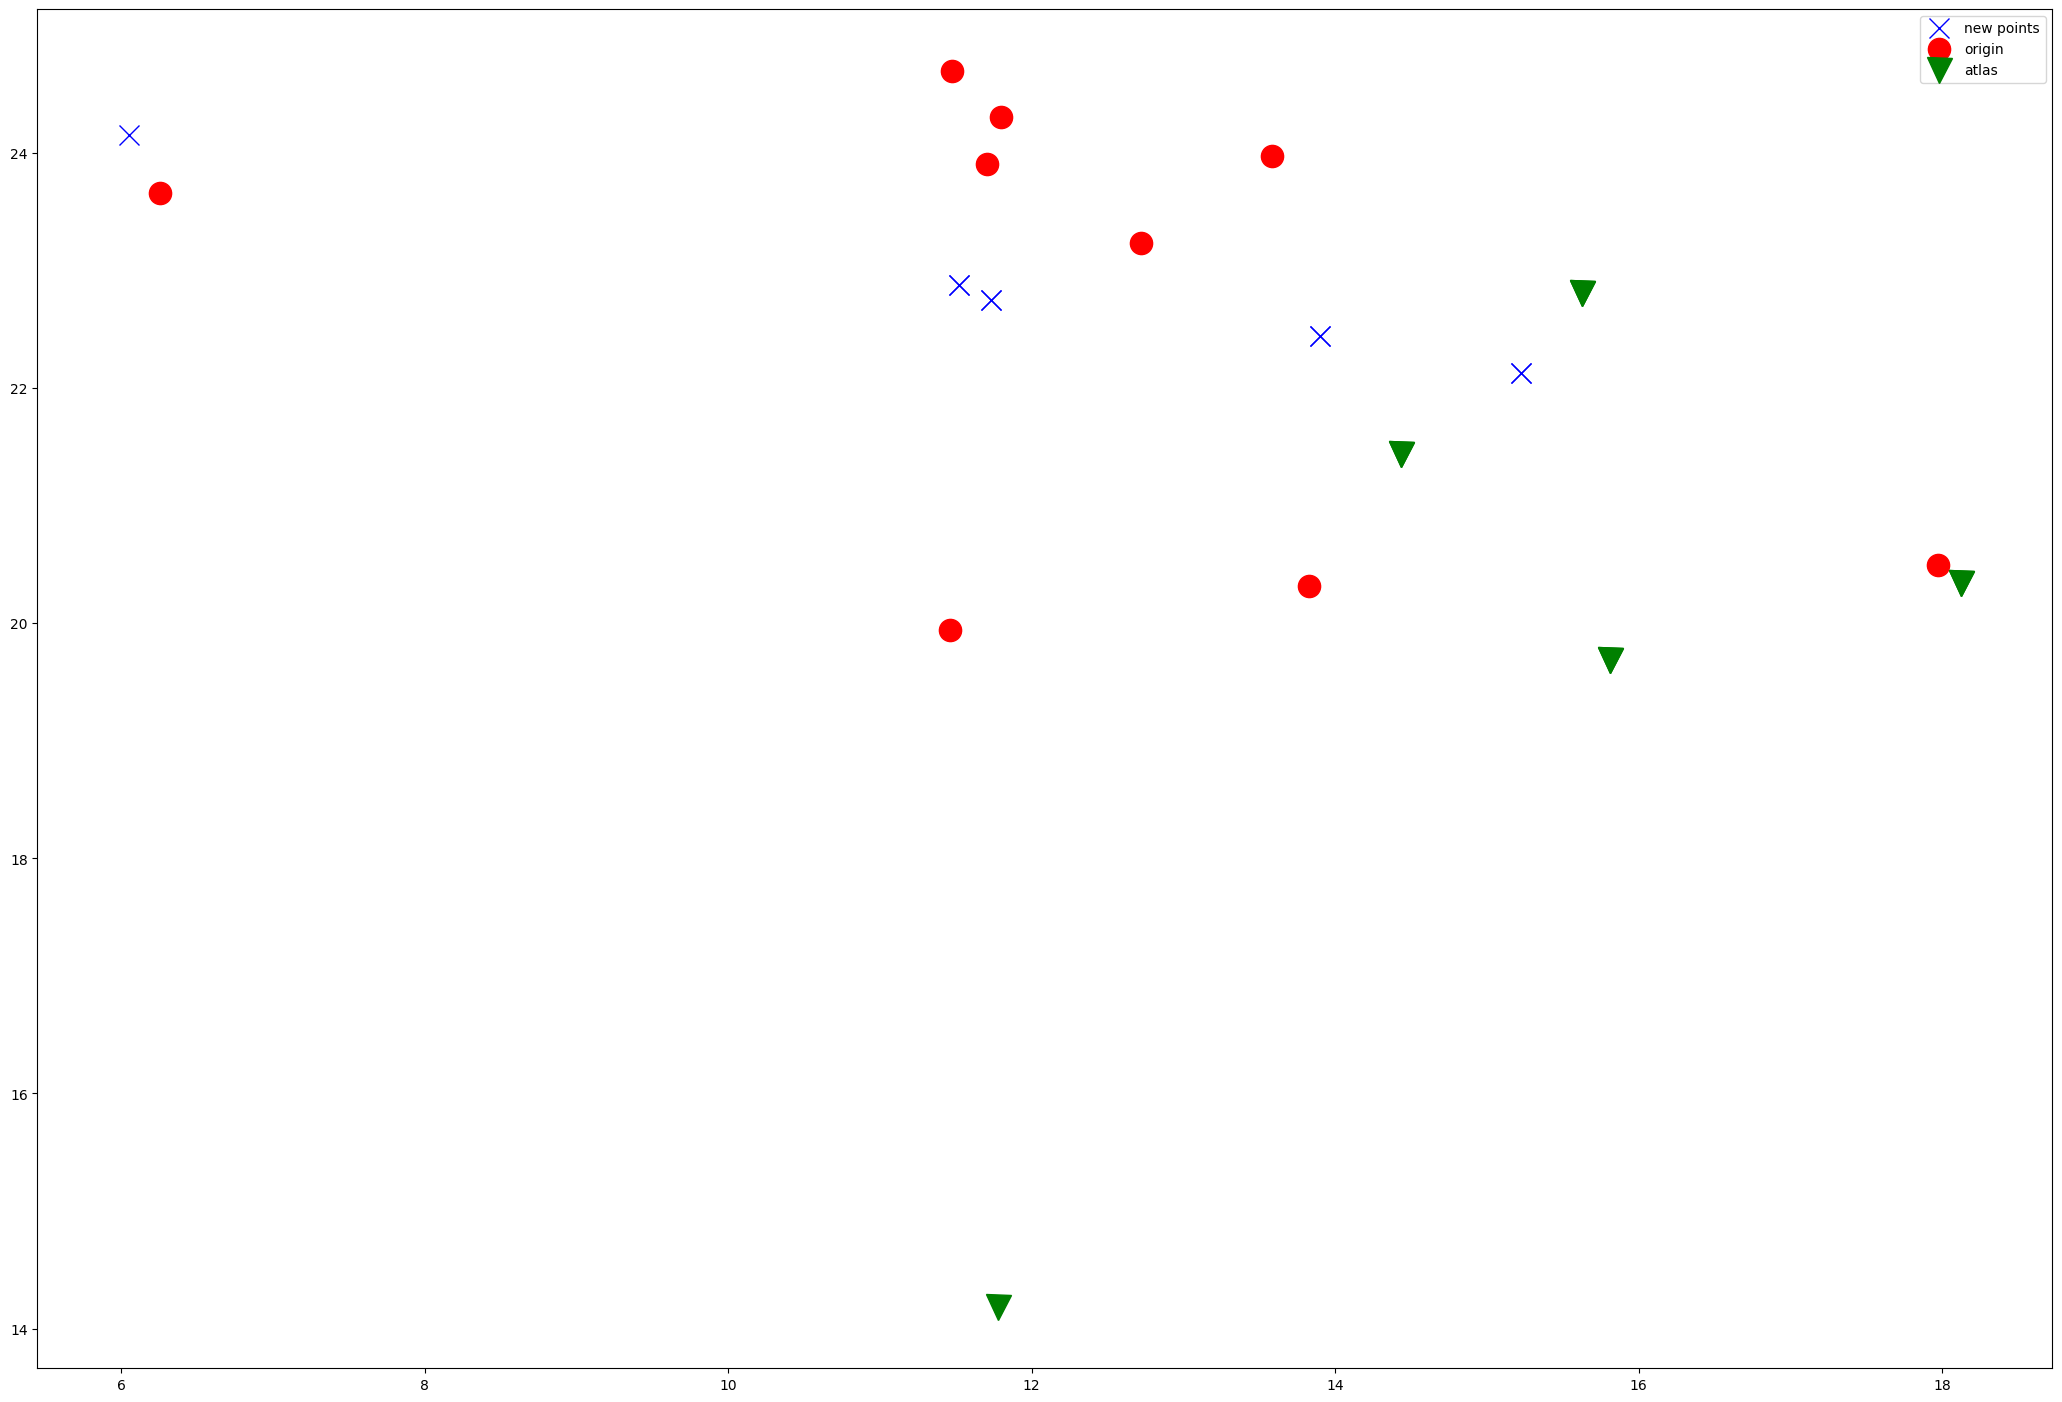

In [34]:
origin_centroid = np.mean(origin, axis=0)
fitted_centroid = np.mean(fitted, axis=0)
colors = 'brg'
new_points = np.empty_like(origin)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')

for i in range(len(origin)):
    new_points[i] = origin_centroid + np.dot(transformation, fitted[i] - fitted_centroid)
    print('point %d will move to (%3.1f, %3.1f) to be compared with (%3.1f, %3.1f)' % (
    i, new_points[i, 0], new_points[i, 1], origin[i, 0], origin[i, 1]))
    plt.plot(new_points[i, 0], new_points[i, 1], 'x', color=colors[0], markersize=14,
             label='new points' if i == 0 else '')
    plt.plot(origin[i, 0], origin[i, 1], 'o', color=colors[1], markersize=16,
             label='origin' if i == 0 else '')
    plt.plot(fitted[i, 0], fitted[i, 1], 'v', color=colors[2], markersize=18,
             label='atlas' if i == 0 else '')
plt.legend(numpoints=1)
plt.show()
